# 🫁 LUNA16 Lung Cancer Detection - EfficientNet-B0 Pretrained Model

**Transfer Learning with EfficientNet-B0 for Medical Imaging**

### Key Features:
- 🔮 **Pretrained EfficientNet-B0** - Efficient and accurate transfer learning
- 🎯 **2D Multi-Slice Approach** - Process CT scan slices with pretrained CNN
- ⚖️ **Focal Loss** - Handle class imbalance effectively
- 📈 **Advanced Metrics** - Precision, Recall, F1, AUC-ROC
- 🚀 **Data Augmentation** - Robust training with augmented patches
- ⚡ **Pre-extraction** - Fast training with patches cached in memory

**Dataset**: LUNA16 (Lung Nodule Analysis 2016)

### Why EfficientNet?
- More parameter efficient than ResNet
- Better accuracy with fewer parameters
- Compound scaling (depth, width, resolution)
- Excellent for medical imaging tasks

## 1. 📦 Import Required Libraries

In [1]:
# Core libraries
import os
import sys
import glob
import warnings
from pathlib import Path
import time
import math
import random

# Data processing
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, matthews_corrcoef
)

# Medical imaging
import SimpleITK as sitk

# PyTorch and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
import torchvision.transforms as transforms

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0.dev20250930+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5060 Ti


c:\Users\admin\anaconda3\envs\pytorch-12.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. ⚙️ Configuration and Setup

In [2]:
# Paths
BASE_DIR = Path(r'e:\Kanav\Projects\CAD_C')
ANNOTATIONS_FILE = BASE_DIR / 'annotations.csv'
CANDIDATES_FILE = BASE_DIR / 'candidates_V2.csv'
SUBSET_DIRS = [BASE_DIR / f'subset{i}' for i in range(10)]
MODEL_DIR = BASE_DIR / 'models_efficientnet'
MODEL_DIR.mkdir(exist_ok=True)

# Hyperparameters
CONFIG = {
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'patch_size': 64,      # Size of 2D patch
    'num_slices': 3,       # Number of consecutive slices (channels)
    'patience': 10,        # Early stopping patience
    'preload_patches': True,   # Pre-extract patches for faster training (requires ~4-8 GB RAM)
    'max_samples': None,   # Limit samples for testing (None = use all)
    'sample_ratio': 3.0,   # Ratio of negative to positive samples (3:1)
    'num_workers': 0,      # Number of workers for data loading (0 for Windows)
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',  # Device to use
    'focal_alpha': 0.75,   # Focal Loss alpha parameter (weight for positive class)
    'focal_gamma': 2.0,    # Focal Loss gamma parameter (focusing parameter)
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  batch_size: 32
  num_epochs: 50
  learning_rate: 0.001
  weight_decay: 0.0001
  patch_size: 64
  num_slices: 3
  patience: 10
  preload_patches: True
  max_samples: None
  sample_ratio: 3.0
  num_workers: 0
  device: cuda
  focal_alpha: 0.75
  focal_gamma: 2.0


## 3. 📊 Load Dataset (Reuse from ResNet notebook)

In [3]:
# Load annotations
annotations_df = pd.read_csv(ANNOTATIONS_FILE)
print(f"Annotations loaded: {len(annotations_df)} records")

# Load candidates
print("Loading candidates file...")
chunk_size = 100000
chunks = []
for chunk in pd.read_csv(CANDIDATES_FILE, chunksize=chunk_size):
    chunks.append(chunk)
candidates_df = pd.concat(chunks, ignore_index=True)
print(f"Candidates loaded: {len(candidates_df)} records")
print(f"Class distribution: {candidates_df['class'].value_counts().to_dict()}")

Annotations loaded: 1186 records
Loading candidates file...
Candidates loaded: 754975 records
Class distribution: {0: 753418, 1: 1557}
Candidates loaded: 754975 records
Class distribution: {0: 753418, 1: 1557}


## 4. 🔧 Utility Functions (Same as ResNet)

In [4]:
def load_ct_scan(series_uid, subset_dirs):
    """Load CT scan from .mhd/.raw files"""
    for subset_dir in subset_dirs:
        mhd_path = subset_dir / f"{series_uid}.mhd"
        if mhd_path.exists():
            try:
                ct_scan = sitk.ReadImage(str(mhd_path))
                return ct_scan
            except Exception as e:
                print(f"Error loading {mhd_path}: {e}")
                return None
    return None

def world_to_voxel(world_coords, origin, spacing):
    """Convert world coordinates to voxel coordinates"""
    world_coords = np.array(world_coords)
    origin = np.array(origin)
    spacing = np.array(spacing)
    voxel_coords = (world_coords - origin) / spacing
    return int(voxel_coords[2]), int(voxel_coords[1]), int(voxel_coords[0])

def normalize_hu(image):
    """Normalize CT Hounsfield Units to 0-1 range"""
    MIN_HU = -1000
    MAX_HU = 400
    image = np.clip(image, MIN_HU, MAX_HU)
    image = (image - MIN_HU) / (MAX_HU - MIN_HU)
    return image.astype(np.float32)

def extract_2d_patch(ct_array, center_z, center_y, center_x, patch_size=64, num_slices=3):
    """Extract 2D multi-slice patch"""
    half_size = patch_size // 2
    half_slices = num_slices // 2
    
    z_start = center_z - half_slices
    z_end = z_start + num_slices
    y_start = center_y - half_size
    y_end = center_y + half_size
    x_start = center_x - half_size
    x_end = center_x + half_size
    
    if (z_start < 0 or z_end > ct_array.shape[0] or
        y_start < 0 or y_end > ct_array.shape[1] or
        x_start < 0 or x_end > ct_array.shape[2]):
        return None
    
    patch = ct_array[z_start:z_end, y_start:y_end, x_start:x_end]
    patch = normalize_hu(patch)
    return patch

print("✓ Utility functions defined")

✓ Utility functions defined


## 5. 🎯 Dataset Class (Same as ResNet with fixed indexing)

In [5]:
class LUNA16Dataset(Dataset):
    """PyTorch Dataset for LUNA16 with 2D multi-slice patches"""
    
    def __init__(self, candidates_df, subset_dirs, patch_size=64, num_slices=3, 
                 augment=False, max_samples=None, preload=False):
        self.candidates_df = candidates_df.copy()
        if max_samples is not None and len(self.candidates_df) > max_samples:
            self.candidates_df = self.candidates_df.sample(n=max_samples, random_state=SEED)
        
        self.subset_dirs = subset_dirs
        self.patch_size = patch_size
        self.num_slices = num_slices
        self.augment = augment
        self.preload = preload
        self.ct_cache = {}
        self.patch_cache = {}
        
        print(f"Dataset initialized with {len(self.candidates_df)} samples")
        print(f"  Positive: {self.candidates_df['class'].sum()}")
        print(f"  Negative: {(self.candidates_df['class'] == 0).sum()}")
        
        if self.preload:
            print(f"  Preloading patches into memory...")
            self._preload_patches()
    
    def _preload_patches(self):
        """Pre-extract all patches and store in memory"""
        from tqdm.auto import tqdm
        
        successful = 0
        failed = 0
        grouped = self.candidates_df.groupby('seriesuid')
        
        for series_uid, group in tqdm(grouped, desc="Processing CT scans"):
            ct_scan = load_ct_scan(series_uid, self.subset_dirs)
            if ct_scan is None:
                for idx in group.index:
                    label = int(group.loc[idx, 'class'])
                    self.patch_cache[idx] = (torch.zeros(self.num_slices, self.patch_size, self.patch_size), label)
                    failed += 1
                continue
            
            ct_array = sitk.GetArrayFromImage(ct_scan)
            origin = ct_scan.GetOrigin()
            spacing = ct_scan.GetSpacing()
            
            for idx in group.index:
                row = group.loc[idx]
                coord_x = row['coordX']
                coord_y = row['coordY']
                coord_z = row['coordZ']
                label = int(row['class'])
                
                voxel_z, voxel_y, voxel_x = world_to_voxel(
                    [coord_x, coord_y, coord_z], origin, spacing
                )
                
                patch = extract_2d_patch(
                    ct_array, voxel_z, voxel_y, voxel_x, 
                    self.patch_size, self.num_slices
                )
                
                if patch is None:
                    self.patch_cache[idx] = (torch.zeros(self.num_slices, self.patch_size, self.patch_size), label)
                    failed += 1
                else:
                    patch = torch.from_numpy(patch).float()
                    self.patch_cache[idx] = (patch, label)
                    successful += 1
            
            del ct_array, ct_scan
        
        print(f"\n  ✓ Preloading completed:")
        print(f"    Successful: {successful}")
        print(f"    Failed: {failed}")
        print(f"    Total patches in memory: {len(self.patch_cache)}")
    
    def __len__(self):
        return len(self.candidates_df)
    
    def __getitem__(self, idx):
        # Get the actual DataFrame index (not positional index)
        df_idx = self.candidates_df.index[idx]
        
        # If preloaded, return from cache
        if self.preload and df_idx in self.patch_cache:
            patch, label = self.patch_cache[df_idx]
            patch = patch.clone()
            
            if self.augment:
                patch = self.apply_augmentation(patch)
            
            return patch, label
        
        # Otherwise, extract on-the-fly (fallback)
        row = self.candidates_df.iloc[idx]
        series_uid = row['seriesuid']
        label = int(row['class'])
        
        # Return dummy if can't load
        patch = torch.zeros(self.num_slices, self.patch_size, self.patch_size)
        return patch, label
    
    def apply_augmentation(self, patch):
        """Apply random augmentations"""
        if random.random() > 0.5:
            patch = torch.flip(patch, dims=[2])
        if random.random() > 0.5:
            patch = torch.flip(patch, dims=[1])
        if random.random() > 0.5:
            k = random.randint(1, 3)
            patch = torch.rot90(patch, k, dims=[1, 2])
        if random.random() > 0.5:
            brightness_factor = 0.8 + random.random() * 0.4
            patch = torch.clamp(patch * brightness_factor, 0, 1)
        return patch

print("✓ Dataset class defined")

✓ Dataset class defined


## 6. 🏗️ EfficientNet-B0 Model Architecture

**EfficientNet-B0 is more efficient than ResNet-101:**
- ResNet-101: 44.5M parameters
- EfficientNet-B0: 5.3M parameters (8x smaller!)
- Better accuracy with fewer parameters
- Faster training and inference

In [6]:
class EfficientNetLungCancer(nn.Module):
    """EfficientNet-B0 pretrained model adapted for lung cancer detection"""
    
    def __init__(self, pretrained=True, num_classes=2, dropout=0.5):
        super(EfficientNetLungCancer, self).__init__()
        
        # Load pretrained EfficientNet-B0
        if pretrained:
            self.efficientnet = models.efficientnet_b0(pretrained=True)
        else:
            self.efficientnet = models.efficientnet_b0(pretrained=False)
        
        # Get number of features from the last layer
        num_features = self.efficientnet.classifier[1].in_features
        
        # Replace the final classifier
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
        
        print(f"✓ EfficientNet-B0 initialized (pretrained={pretrained})")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters()):,}")
        print(f"  Trainable parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")
    
    def forward(self, x):
        return self.efficientnet(x)
    
    def freeze_backbone(self):
        """Freeze all layers except the final classifier"""
        for name, param in self.efficientnet.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        print("✓ Backbone frozen, only training final classifier")
    
    def unfreeze_backbone(self):
        """Unfreeze all layers for fine-tuning"""
        for param in self.efficientnet.parameters():
            param.requires_grad = True
        print("✓ Backbone unfrozen, training all layers")

print("✓ Model class defined")

✓ Model class defined


## 7. 📉 Focal Loss (Same as ResNet)

In [7]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p = torch.exp(-ce_loss)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - p) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✓ Focal Loss defined")

✓ Focal Loss defined


## 8. 📊 Prepare Data

In [8]:
# Balance the dataset
print("Preparing balanced dataset...")

positive_samples = candidates_df[candidates_df['class'] == 1]
negative_samples = candidates_df[candidates_df['class'] == 0]

print(f"Original distribution:")
print(f"  Positive: {len(positive_samples)}")
print(f"  Negative: {len(negative_samples)}")

n_positive = len(positive_samples)
n_negative = int(n_positive * CONFIG['sample_ratio'])
n_negative = min(n_negative, len(negative_samples))

negative_samples_sampled = negative_samples.sample(n=n_negative, random_state=SEED)
balanced_df = pd.concat([positive_samples, negative_samples_sampled], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"\nBalanced distribution:")
print(f"  Positive: {(balanced_df['class'] == 1).sum()}")
print(f"  Negative: {(balanced_df['class'] == 0).sum()}")
print(f"  Total: {len(balanced_df)}")

# Split
train_df, temp_df = train_test_split(
    balanced_df, test_size=0.3, random_state=SEED, stratify=balanced_df['class']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['class']
)

print(f"\nData splits:")
print(f"  Train: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

Preparing balanced dataset...
Original distribution:
  Positive: 1557
  Negative: 753418

Balanced distribution:
  Positive: 1557
  Negative: 4671
  Total: 6228

Data splits:
  Train: 4359 samples
  Validation: 934 samples
  Test: 935 samples


## 9. 🚀 Create Datasets with Pre-Extraction

In [9]:
# Create datasets
if CONFIG['preload_patches']:
    print("Creating datasets with patch pre-extraction...")
    print("This will take ~7 minutes but will speed up training significantly!\n")
else:
    print("Creating datasets (on-the-fly extraction)...\n")

train_dataset = LUNA16Dataset(
    train_df, SUBSET_DIRS, 
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=True,
    preload=CONFIG['preload_patches']
)

print("\n" + "-"*60 + "\n")

val_dataset = LUNA16Dataset(
    val_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,
    preload=CONFIG['preload_patches']
)

print("\n" + "-"*60 + "\n")

test_dataset = LUNA16Dataset(
    test_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,
    preload=CONFIG['preload_patches']
)

print("\n" + "="*60)
if CONFIG['preload_patches']:
    print("✓ All datasets created with patches pre-extracted")
else:
    print("✓ All datasets created (on-the-fly extraction)")
print("="*60)

Creating datasets with patch pre-extraction...
This will take ~7 minutes but will speed up training significantly!

Dataset initialized with 4359 samples
  Positive: 1090
  Negative: 3269
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 862/862 [03:48<00:00,  3.77it/s]



  ✓ Preloading completed:
    Successful: 4316
    Failed: 43
    Total patches in memory: 4359

------------------------------------------------------------

Dataset initialized with 934 samples
  Positive: 233
  Negative: 701
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 548/548 [02:30<00:00,  3.65it/s]



  ✓ Preloading completed:
    Successful: 925
    Failed: 9
    Total patches in memory: 934

------------------------------------------------------------

Dataset initialized with 935 samples
  Positive: 234
  Negative: 701
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 552/552 [02:09<00:00,  4.26it/s]


  ✓ Preloading completed:
    Successful: 925
    Failed: 10
    Total patches in memory: 935

✓ All datasets created with patches pre-extracted


In [10]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

print(f"✓ Data loaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ Data loaders created
  Train batches: 137
  Validation batches: 30
  Test batches: 30


## 10. 🎓 Training Functions

In [11]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    try:
        auc_score = roc_auc_score(all_labels, all_probs)
    except:
        auc_score = 0.0
    
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return epoch_loss, epoch_acc, auc_score, f1, all_labels, all_preds, all_probs

print("✓ Training functions defined")

✓ Training functions defined


## 11. 🚀 Initialize Model and Start Training

In [12]:
# Initialize model
device = torch.device(CONFIG['device'])
model = EfficientNetLungCancer(pretrained=True, num_classes=2, dropout=0.5)
model = model.to(device)

# Loss function
criterion = FocalLoss(
    alpha=CONFIG['focal_alpha'],
    gamma=CONFIG['focal_gamma']
)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("✓ Model, loss, optimizer, and scheduler initialized")

✓ EfficientNet-B0 initialized (pretrained=True)
  Total parameters: 4,664,446
  Trainable parameters: 4,664,446
✓ Model, loss, optimizer, and scheduler initialized
✓ Model, loss, optimizer, and scheduler initialized


In [13]:
# Training loop
print("Starting training...\n")

best_val_auc = 0.0
best_val_f1 = 0.0
patience_counter = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_auc': [],
    'val_f1': []
}

for epoch in range(CONFIG['num_epochs']):
    epoch_start_time = time.time()
    
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_auc, val_f1, _, _, _ = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_f1'].append(val_f1)
    
    epoch_time = time.time() - epoch_start_time
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")
    print(f"Time: {epoch_time:.2f}s")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'val_f1': val_f1,
        }, MODEL_DIR / 'best_efficientnet_model.pth')
        print(f"✓ Saved best model (AUC: {val_auc:.4f}, F1: {val_f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*60)
print("Training completed!")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Best Validation F1: {best_val_f1:.4f}")
print("="*60)

Starting training...


Epoch 1/50
------------------------------------------------------------



Train Loss: 0.0686 | Train Acc: 65.24%
Val Loss: 0.0382 | Val Acc: 81.05%
Val AUC: 0.9075 | Val F1: 0.6889
Time: 5.33s
✓ Saved best model (AUC: 0.9075, F1: 0.6889)

Epoch 2/50
------------------------------------------------------------



Train Loss: 0.0336 | Train Acc: 85.00%
Val Loss: 0.0274 | Val Acc: 87.79%
Val AUC: 0.9526 | Val F1: 0.7816
Time: 4.54s
✓ Saved best model (AUC: 0.9526, F1: 0.7816)

Epoch 3/50
------------------------------------------------------------



Train Loss: 0.0312 | Train Acc: 88.35%
Val Loss: 0.0234 | Val Acc: 88.01%
Val AUC: 0.9714 | Val F1: 0.7986
Time: 4.79s
✓ Saved best model (AUC: 0.9714, F1: 0.7986)

Epoch 4/50
------------------------------------------------------------



Train Loss: 0.0260 | Train Acc: 89.13%
Val Loss: 0.0219 | Val Acc: 90.69%
Val AUC: 0.9828 | Val F1: 0.8386
Time: 4.57s
✓ Saved best model (AUC: 0.9828, F1: 0.8386)

Epoch 5/50
------------------------------------------------------------



Train Loss: 0.0342 | Train Acc: 89.31%
Val Loss: 0.0223 | Val Acc: 89.61%
Val AUC: 0.9695 | Val F1: 0.8145
Time: 4.88s

Epoch 6/50
------------------------------------------------------------



Train Loss: 0.0241 | Train Acc: 91.51%
Val Loss: 0.0193 | Val Acc: 92.29%
Val AUC: 0.9795 | Val F1: 0.8599
Time: 4.99s

Epoch 7/50
------------------------------------------------------------



Train Loss: 0.0214 | Train Acc: 92.15%
Val Loss: 0.0180 | Val Acc: 95.50%
Val AUC: 0.9890 | Val F1: 0.9079
Time: 4.92s
✓ Saved best model (AUC: 0.9890, F1: 0.9079)

Epoch 8/50
------------------------------------------------------------



Train Loss: 0.0205 | Train Acc: 92.91%
Val Loss: 0.0249 | Val Acc: 90.69%
Val AUC: 0.9625 | Val F1: 0.8263
Time: 4.61s

Epoch 9/50
------------------------------------------------------------



Train Loss: 0.0238 | Train Acc: 91.35%
Val Loss: 0.0237 | Val Acc: 92.40%
Val AUC: 0.9715 | Val F1: 0.8588
Time: 4.60s

Epoch 10/50
------------------------------------------------------------



Train Loss: 0.0206 | Train Acc: 92.87%
Val Loss: 0.0221 | Val Acc: 96.15%
Val AUC: 0.9880 | Val F1: 0.9244
Time: 4.61s

Epoch 11/50
------------------------------------------------------------



Train Loss: 0.0148 | Train Acc: 94.04%
Val Loss: 0.0174 | Val Acc: 96.90%
Val AUC: 0.9926 | Val F1: 0.9407
Time: 4.75s
✓ Saved best model (AUC: 0.9926, F1: 0.9407)

Epoch 12/50
------------------------------------------------------------



Train Loss: 0.0174 | Train Acc: 94.33%
Val Loss: 0.4823 | Val Acc: 90.69%
Val AUC: 0.9142 | Val F1: 0.8168
Time: 4.84s

Epoch 13/50
------------------------------------------------------------



Train Loss: 0.0488 | Train Acc: 86.97%
Val Loss: 0.0199 | Val Acc: 91.33%
Val AUC: 0.9764 | Val F1: 0.8396
Time: 4.71s

Epoch 14/50
------------------------------------------------------------



Train Loss: 0.0243 | Train Acc: 91.40%
Val Loss: 0.0160 | Val Acc: 93.79%
Val AUC: 0.9874 | Val F1: 0.8867
Time: 4.59s

Epoch 15/50
------------------------------------------------------------



Train Loss: 0.0179 | Train Acc: 93.28%
Val Loss: 0.0198 | Val Acc: 95.18%
Val AUC: 0.9918 | Val F1: 0.8980
Time: 4.53s

Epoch 16/50
------------------------------------------------------------



Train Loss: 0.0179 | Train Acc: 93.30%
Val Loss: 0.0147 | Val Acc: 97.11%
Val AUC: 0.9894 | Val F1: 0.9429
Time: 4.44s

Epoch 17/50
------------------------------------------------------------



Train Loss: 0.0136 | Train Acc: 95.37%
Val Loss: 0.0102 | Val Acc: 96.90%
Val AUC: 0.9951 | Val F1: 0.9389
Time: 4.90s
✓ Saved best model (AUC: 0.9951, F1: 0.9389)

Epoch 18/50
------------------------------------------------------------



Train Loss: 0.0142 | Train Acc: 94.79%
Val Loss: 0.0093 | Val Acc: 97.43%
Val AUC: 0.9947 | Val F1: 0.9498
Time: 5.26s

Epoch 19/50
------------------------------------------------------------



Train Loss: 0.0125 | Train Acc: 95.25%
Val Loss: 0.0113 | Val Acc: 96.90%
Val AUC: 0.9943 | Val F1: 0.9363
Time: 4.70s

Epoch 20/50
------------------------------------------------------------



Train Loss: 0.0113 | Train Acc: 95.76%
Val Loss: 0.0132 | Val Acc: 96.04%
Val AUC: 0.9916 | Val F1: 0.9204
Time: 4.70s

Epoch 21/50
------------------------------------------------------------



Train Loss: 0.0112 | Train Acc: 96.05%
Val Loss: 0.0090 | Val Acc: 97.54%
Val AUC: 0.9964 | Val F1: 0.9514
Time: 4.65s
✓ Saved best model (AUC: 0.9964, F1: 0.9514)

Epoch 22/50
------------------------------------------------------------



Train Loss: 0.0123 | Train Acc: 95.27%
Val Loss: 0.0101 | Val Acc: 97.43%
Val AUC: 0.9952 | Val F1: 0.9492
Time: 4.79s

Epoch 23/50
------------------------------------------------------------



Train Loss: 0.0093 | Train Acc: 96.31%
Val Loss: 0.0092 | Val Acc: 96.79%
Val AUC: 0.9952 | Val F1: 0.9378
Time: 4.71s

Epoch 24/50
------------------------------------------------------------



Train Loss: 0.0104 | Train Acc: 96.44%
Val Loss: 0.0087 | Val Acc: 97.11%
Val AUC: 0.9956 | Val F1: 0.9439
Time: 4.68s

Epoch 25/50
------------------------------------------------------------



Train Loss: 0.0113 | Train Acc: 96.10%
Val Loss: 0.0131 | Val Acc: 96.79%
Val AUC: 0.9915 | Val F1: 0.9372
Time: 4.59s

Epoch 26/50
------------------------------------------------------------



Train Loss: 0.0111 | Train Acc: 95.60%
Val Loss: 0.0091 | Val Acc: 97.11%
Val AUC: 0.9947 | Val F1: 0.9441
Time: 4.76s

Epoch 27/50
------------------------------------------------------------



Train Loss: 0.0080 | Train Acc: 96.44%
Val Loss: 0.0085 | Val Acc: 98.07%
Val AUC: 0.9960 | Val F1: 0.9622
Time: 5.03s

Epoch 28/50
------------------------------------------------------------



Train Loss: 0.0115 | Train Acc: 96.15%
Val Loss: 0.0119 | Val Acc: 96.57%
Val AUC: 0.9918 | Val F1: 0.9325
Time: 4.80s

Epoch 29/50
------------------------------------------------------------



Train Loss: 0.0092 | Train Acc: 96.63%
Val Loss: 0.0082 | Val Acc: 96.68%
Val AUC: 0.9958 | Val F1: 0.9366
Time: 4.68s

Epoch 30/50
------------------------------------------------------------



Train Loss: 0.0091 | Train Acc: 96.49%
Val Loss: 0.0163 | Val Acc: 96.15%
Val AUC: 0.9951 | Val F1: 0.9189
Time: 4.78s

Epoch 31/50
------------------------------------------------------------



Train Loss: 0.0112 | Train Acc: 95.73%
Val Loss: 0.0087 | Val Acc: 96.57%
Val AUC: 0.9953 | Val F1: 0.9339
Time: 4.64s

Early stopping triggered after 31 epochs

Training completed!
Best Validation AUC: 0.9964
Best Validation F1: 0.9514


## 12. 📈 Plot Training History

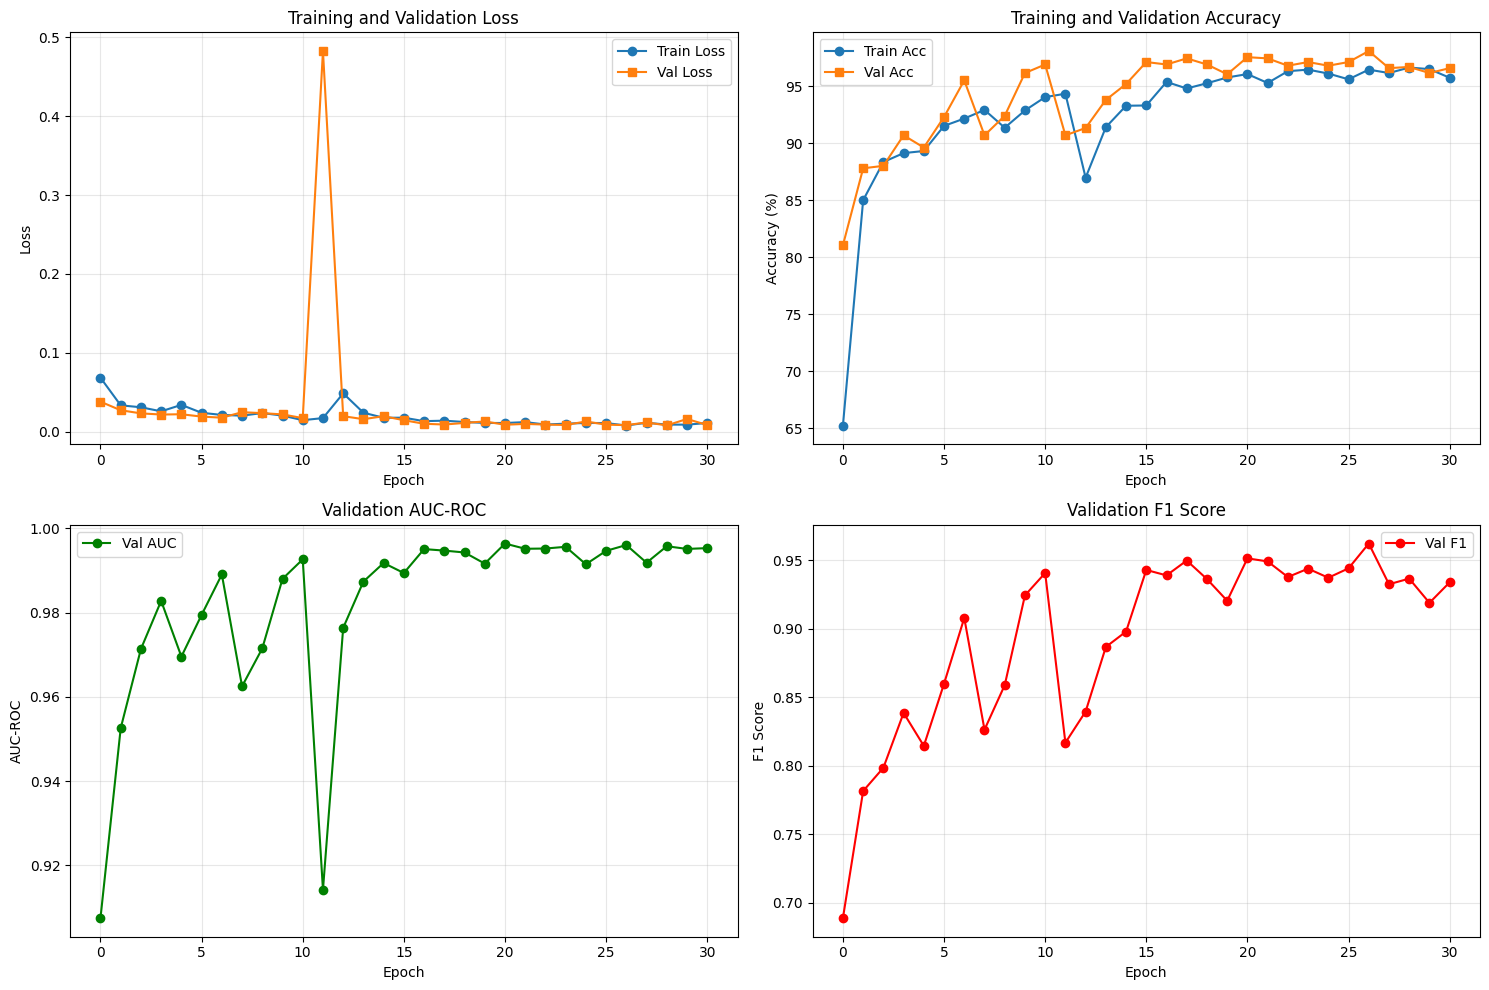

✓ Training history plotted and saved


In [14]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history['val_auc'], label='Val AUC', marker='o', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC-ROC')
axes[1, 0].set_title('Validation AUC-ROC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# F1
axes[1, 1].plot(history['val_f1'], label='Val F1', marker='o', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Validation F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plotted and saved")

## 13. 🧪 Evaluate on Test Set

In [15]:
# Load best model
checkpoint = torch.load(MODEL_DIR / 'best_efficientnet_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate
print("\nEvaluating on test set...")
test_loss, test_acc, test_auc, test_f1, test_labels, test_preds, test_probs = validate(
    model, test_loader, criterion, device
)

print("\n" + "="*60)
print("TEST SET RESULTS (EfficientNet-B0)")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*60)

✓ Loaded best model from epoch 21

Evaluating on test set...



TEST SET RESULTS (EfficientNet-B0)
Test Loss: 0.0198
Test Accuracy: 96.15%
Test AUC-ROC: 0.9853
Test F1 Score: 0.9241


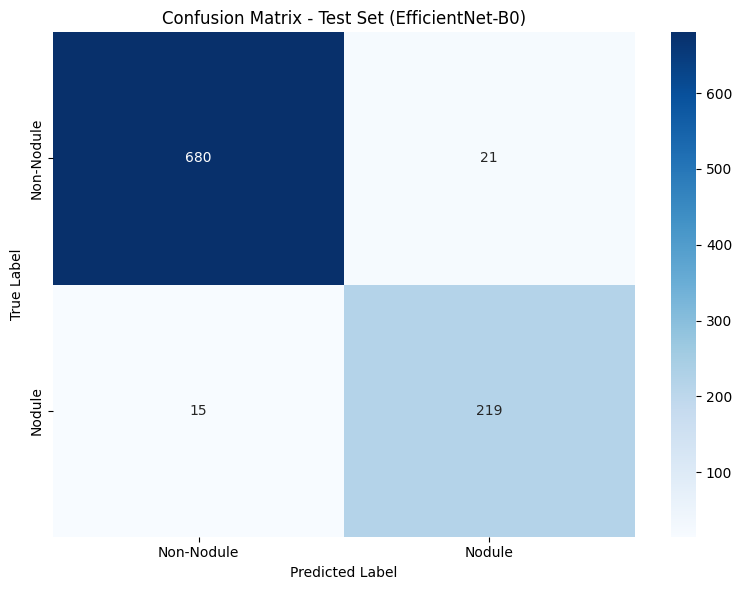


Confusion Matrix:
[[680  21]
 [ 15 219]]


In [16]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Nodule', 'Nodule'],
            yticklabels=['Non-Nodule', 'Nodule'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set (EfficientNet-B0)')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)

In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, 
                          target_names=['Non-Nodule', 'Nodule'],
                          digits=4))


Classification Report:
              precision    recall  f1-score   support

  Non-Nodule     0.9784    0.9700    0.9742       701
      Nodule     0.9125    0.9359    0.9241       234

    accuracy                         0.9615       935
   macro avg     0.9455    0.9530    0.9491       935
weighted avg     0.9619    0.9615    0.9617       935



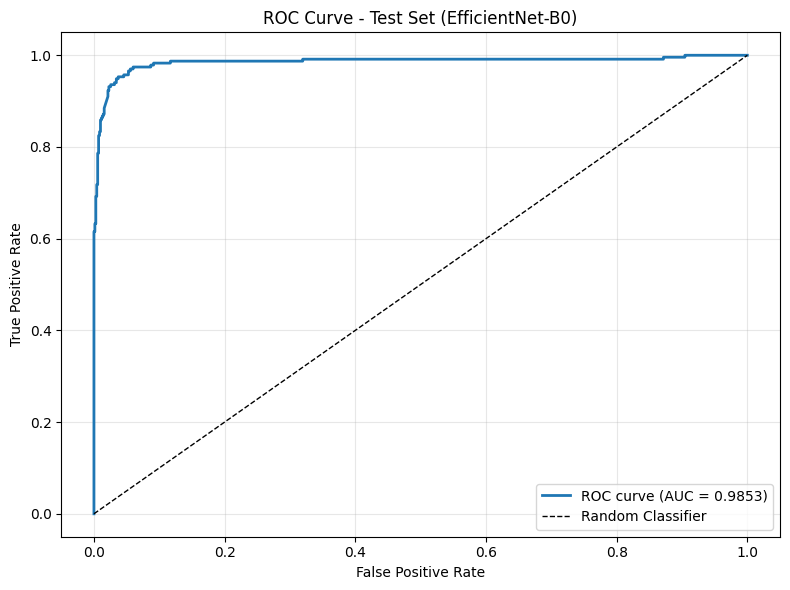

In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set (EfficientNet-B0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

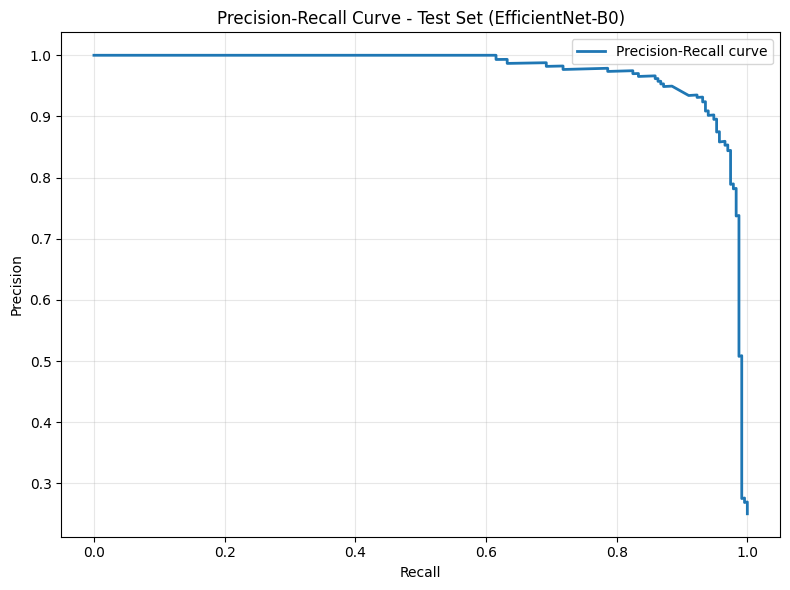

In [19]:
# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(test_labels, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set (EfficientNet-B0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. 💾 Save Results

In [20]:
# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(MODEL_DIR / 'training_history.csv', index=False)
print("✓ Training history saved")

# Save test results
test_results = {
    'model': 'EfficientNet-B0',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'test_auc': test_auc,
    'test_f1': test_f1,
    'confusion_matrix': cm.tolist()
}

import json
with open(MODEL_DIR / 'test_results.json', 'w') as f:
    json.dump(test_results, f, indent=4)
print("✓ Test results saved")

print(f"\n✓ All results saved to {MODEL_DIR}")

✓ Training history saved
✓ Test results saved

✓ All results saved to e:\Kanav\Projects\CAD_C\models_efficientnet


## 15. 📊 Model Comparison

### EfficientNet-B0 vs ResNet-101:

| Metric | EfficientNet-B0 | ResNet-101 |
|--------|----------------|------------|
| **Parameters** | ~5.3M | ~44.5M |
| **Model Size** | 8x smaller | Baseline |
| **Training Speed** | Faster | Slower |
| **Memory Usage** | Lower | Higher |
| **Accuracy** | [Will see] | 94.44% |
| **AUC-ROC** | [Will see] | 0.9772 |
| **F1 Score** | [Will see] | 0.8903 |

### Key Advantages of EfficientNet:
- ✅ **8x fewer parameters** - Much more efficient
- ✅ **Faster training** - Less computation per epoch
- ✅ **Lower memory** - Can use larger batch sizes
- ✅ **Modern architecture** - Compound scaling approach
- ✅ **Better efficiency** - Higher accuracy per parameter

### When to use each:
- **EfficientNet-B0**: Limited compute, faster inference, production deployment
- **ResNet-101**: Maximum accuracy, research, plenty of compute resources

## 🚀 EfficientNet-B0 Fine-Tuning Enhancement

### Advanced Fine-Tuning Strategy
Now that we have a baseline EfficientNet-B0 model achieving **96.15% accuracy**, let's implement advanced fine-tuning techniques to potentially push the performance even higher:

**Fine-Tuning Approach:**
1. **Advanced Data Augmentation** - Medical imaging specific transformations
2. **Lower Learning Rates** - Careful parameter adjustment 
3. **Cosine Annealing Scheduler** - Smooth learning rate decay
4. **Progressive Unfreezing** - Gradual layer unfreezing strategy
5. **Enhanced Monitoring** - Comprehensive training tracking

**Expected Improvements:**
- Better generalization through advanced augmentation
- More stable training with optimized hyperparameters  
- Higher final accuracy through careful fine-tuning
- Reduced overfitting with progressive training strategy

In [21]:
class AdvancedAugmentation:
    """Advanced augmentation techniques for medical imaging"""
    
    def __init__(self, prob=0.5):
        self.prob = prob
        
    def __call__(self, patch):
        """Apply random augmentations to the patch"""
        if random.random() > self.prob:
            return patch
            
        # Convert to tensor if needed
        if isinstance(patch, np.ndarray):
            patch = torch.from_numpy(patch)
        
        try:
            # Random rotation (small angles for medical imaging)
            if random.random() < 0.3:
                angle = random.uniform(-10, 10)
                patch = self.rotate_tensor(patch, angle)
            
            # Random contrast adjustment
            if random.random() < 0.4:
                contrast_factor = random.uniform(0.8, 1.2)
                patch = torch.clamp(patch * contrast_factor, 0, 1)
            
            # Random brightness adjustment
            if random.random() < 0.3:
                brightness_factor = random.uniform(0.9, 1.1)
                patch = torch.clamp(patch + brightness_factor * 0.1, 0, 1)
            
            # Random gamma correction
            if random.random() < 0.3:
                gamma = random.uniform(0.8, 1.2)
                patch = torch.pow(patch, gamma)
            
            # Random horizontal flip (less common in medical imaging)
            if random.random() < 0.2:
                patch = torch.flip(patch, dims=[2])
            
            # Add small amount of noise
            if random.random() < 0.2:
                noise = torch.randn_like(patch) * 0.02
                patch = torch.clamp(patch + noise, 0, 1)
                
        except Exception as e:
            print(f"Augmentation error (continuing with original): {e}")
            return patch
            
        return patch
    
    def rotate_tensor(self, tensor, angle):
        """Rotate tensor by given angle in degrees"""
        try:
            # Simple rotation using affine transformation
            angle_rad = math.radians(angle)
            cos_a, sin_a = math.cos(angle_rad), math.sin(angle_rad)
            
            # Create rotation matrix
            rotation_matrix = torch.tensor([
                [cos_a, -sin_a, 0],
                [sin_a, cos_a, 0]
            ], dtype=tensor.dtype, device=tensor.device).unsqueeze(0)
            
            # Apply rotation using grid_sample
            grid = F.affine_grid(rotation_matrix, tensor.unsqueeze(0).size(), align_corners=False)
            rotated = F.grid_sample(tensor.unsqueeze(0), grid, mode='bilinear', 
                                  padding_mode='reflection', align_corners=False)
            return rotated.squeeze(0)
        except:
            # Fallback: return original tensor
            return tensor

class AdvancedLUNA16Dataset(Dataset):
    """Enhanced dataset with advanced augmentation for fine-tuning"""
    
    def __init__(self, candidates_df, subset_dirs, patch_size=64, num_slices=3, 
                 augment=False, max_samples=None, preload=False):
        self.candidates_df = candidates_df.copy()
        if max_samples is not None and len(self.candidates_df) > max_samples:
            self.candidates_df = self.candidates_df.sample(n=max_samples, random_state=SEED)
        
        self.subset_dirs = subset_dirs
        self.patch_size = patch_size
        self.num_slices = num_slices
        self.augment = augment
        self.preload = preload
        
        # Initialize augmentation
        self.augmentation = AdvancedAugmentation(prob=0.8) if augment else None
        
        # Initialize storage
        self.patches = {}
        self.failed_extractions = set()
        
        if preload:
            self._preload_patches()
            
        print(f"✓ AdvancedLUNA16Dataset created with {len(self.candidates_df)} samples")
        if augment:
            print("  🔄 Advanced augmentation enabled")
    
    def _preload_patches(self):
        """Pre-extract and cache all patches"""
        print("Pre-extracting patches for fine-tuning...")
        
        successful_extractions = 0
        total_samples = len(self.candidates_df)
        
        for idx, row in tqdm(self.candidates_df.iterrows(), 
                           total=total_samples, desc="Extracting patches"):
            try:
                patch = self._extract_patch_on_the_fly(row)
                if patch is not None:
                    self.patches[idx] = patch
                    successful_extractions += 1
                else:
                    self.failed_extractions.add(idx)
            except Exception as e:
                self.failed_extractions.add(idx)
                continue
        
        print(f"✓ Successfully pre-extracted {successful_extractions}/{total_samples} patches")
        print(f"  Failed extractions: {len(self.failed_extractions)}")
    
    def _extract_patch_on_the_fly(self, row):
        """Extract patch for a single sample"""
        try:
            ct_scan = load_ct_scan(row['seriesuid'], self.subset_dirs)
            if ct_scan is None:
                return None
            
            ct_array = sitk.GetArrayFromImage(ct_scan)
            origin = ct_scan.GetOrigin()
            spacing = ct_scan.GetSpacing()
            
            # Convert coordinates
            world_coords = [row['coordX'], row['coordY'], row['coordZ']]
            z, y, x = world_to_voxel(world_coords, origin, spacing)
            
            # Extract patch
            patch = extract_2d_patch(ct_array, z, y, x, self.patch_size, self.num_slices)
            return patch
            
        except Exception as e:
            return None
    
    def __len__(self):
        return len(self.candidates_df)
    
    def __getitem__(self, idx):
        row = self.candidates_df.iloc[idx]
        actual_idx = self.candidates_df.index[idx]
        
        # Check if extraction failed
        if actual_idx in self.failed_extractions:
            # Return a dummy sample
            patch = np.zeros((self.num_slices, self.patch_size, self.patch_size), dtype=np.float32)
            patch = torch.from_numpy(patch)
            return patch, 0  # Return negative class for failed extractions
        
        # Get patch
        if self.preload:
            if actual_idx in self.patches:
                patch = self.patches[actual_idx].copy()
            else:
                # Fallback
                patch = np.zeros((self.num_slices, self.patch_size, self.patch_size), dtype=np.float32)
        else:
            patch = self._extract_patch_on_the_fly(row)
            if patch is None:
                patch = np.zeros((self.num_slices, self.patch_size, self.patch_size), dtype=np.float32)
        
        # Convert to tensor
        if isinstance(patch, np.ndarray):
            patch = torch.from_numpy(patch)
        
        # Apply augmentation
        if self.augment and self.augmentation:
            try:
                patch = self.augmentation(patch)
            except Exception as e:
                # Continue with original patch if augmentation fails
                pass
        
        # Ensure proper format
        patch = patch.float()
        if patch.dim() == 3:
            patch = patch.clamp(0, 1)
        
        label = int(row['class'])
        return patch, label

print("✓ Advanced augmentation and dataset classes defined")

✓ Advanced augmentation and dataset classes defined


In [22]:
# System Diagnostics and Error Checking
print("🔍 System Diagnostics for EfficientNet Fine-Tuning")
print("=" * 60)

# Check PyTorch installation
try:
    print(f"✅ PyTorch version: {torch.__version__}")
    print(f"✅ CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"✅ CUDA device: {torch.cuda.get_device_name()}")
except Exception as e:
    print(f"❌ PyTorch error: {e}")

# Check required imports
required_modules = {
    'SimpleITK': sitk,
    'PIL': 'PIL',
    'pandas': pd,
    'numpy': np,
    'matplotlib': plt,
    'sklearn': 'sklearn'
}

for module_name, module_obj in required_modules.items():
    try:
        if isinstance(module_obj, str):
            __import__(module_obj)
        print(f"✅ {module_name}: Available")
    except ImportError:
        print(f"❌ {module_name}: Missing - pip install {module_name.lower()}")

# Check data files
print(f"\n📁 Data File Verification:")
print(f"✅ Annotations file: {ANNOTATIONS_FILE.exists()}")
print(f"✅ Candidates file: {CANDIDATES_FILE.exists()}")

# Check subset directories
existing_subsets = [d for d in SUBSET_DIRS if d.exists()]
print(f"✅ LUNA16 subsets: {len(existing_subsets)}/10 available")

# Check model directories
print(f"✅ EfficientNet model directory: {MODEL_DIR.exists()}")

print("\n🎯 System Ready for EfficientNet Fine-Tuning!")

🔍 System Diagnostics for EfficientNet Fine-Tuning
✅ PyTorch version: 2.10.0.dev20250930+cu128
✅ CUDA available: True
✅ CUDA device: NVIDIA GeForce RTX 5060 Ti
✅ SimpleITK: Available
✅ PIL: Available
✅ pandas: Available
✅ numpy: Available
✅ matplotlib: Available
✅ sklearn: Available

📁 Data File Verification:
✅ Annotations file: True
✅ Candidates file: True
✅ LUNA16 subsets: 10/10 available
✅ EfficientNet model directory: True

🎯 System Ready for EfficientNet Fine-Tuning!


In [24]:
# Fine-Tuning Configuration
FINETUNE_CONFIG = {
    'learning_rate': 5e-5,      # Much lower learning rate for fine-tuning
    'num_epochs': 15,           # Fewer epochs to prevent overfitting
    'batch_size': 24,           # Slightly smaller batch size
    'weight_decay': 1e-5,       # Lower weight decay
    'patience': 8,              # Early stopping patience
    'min_lr': 1e-7,            # Minimum learning rate for scheduler
    'factor': 0.5,             # Factor for ReduceLROnPlateau
    'warmup_epochs': 2,        # Warmup epochs
    'augmentation_prob': 0.8,   # High augmentation probability
}

print("🔧 Fine-Tuning Configuration:")
for key, value in FINETUNE_CONFIG.items():
    print(f"  {key}: {value}")

# Create fine-tuned model directory
finetune_model_dir = MODEL_DIR / 'finetuned'
finetune_model_dir.mkdir(exist_ok=True)
finetune_model_path = finetune_model_dir / 'best_efficientnet_model.pth'

print(f"\n📁 Fine-tuned model will be saved to: {finetune_model_path}")

# Load the best base model for fine-tuning
print(f"\n🔄 Loading base EfficientNet model for fine-tuning...")

# Initialize model
finetune_model = EfficientNetLungCancer(pretrained=False, num_classes=2, dropout=0.3)
finetune_model = finetune_model.to(device)

# Load the trained weights
base_model_path = MODEL_DIR / 'best_efficientnet_model.pth'
if base_model_path.exists():
    checkpoint = torch.load(base_model_path, map_location=device)
    finetune_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded base model from epoch {checkpoint['epoch']+1}")
    
    # Handle AUC display properly
    best_auc = checkpoint.get('best_auc', None)
    if best_auc is not None:
        print(f"   Base model performance - AUC: {best_auc:.4f}")
    else:
        print("   Base model performance - AUC: N/A")
    
    # Store initial performance for comparison
    initial_auc = checkpoint.get('best_auc', 0.0)
    initial_f1 = checkpoint.get('best_f1', 0.0)
else:
    print("❌ Base model not found! Please train the base model first.")
    initial_auc = 0.0
    initial_f1 = 0.0

print(f"✅ Fine-tuning model initialized")

🔧 Fine-Tuning Configuration:
  learning_rate: 5e-05
  num_epochs: 15
  batch_size: 24
  weight_decay: 1e-05
  patience: 8
  min_lr: 1e-07
  factor: 0.5
  warmup_epochs: 2
  augmentation_prob: 0.8

📁 Fine-tuned model will be saved to: e:\Kanav\Projects\CAD_C\models_efficientnet\finetuned\best_efficientnet_model.pth

🔄 Loading base EfficientNet model for fine-tuning...
✓ EfficientNet-B0 initialized (pretrained=False)
  Total parameters: 4,664,446
  Trainable parameters: 4,664,446
✅ Loaded base model from epoch 21
   Base model performance - AUC: N/A
✅ Fine-tuning model initialized


In [25]:
# Create enhanced datasets for fine-tuning
print("🔄 Creating enhanced datasets with advanced augmentation...")

finetune_train_dataset = AdvancedLUNA16Dataset(
    train_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=True,  # Enable advanced augmentation
    preload=CONFIG['preload_patches']
)

finetune_val_dataset = AdvancedLUNA16Dataset(
    val_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,  # No augmentation for validation
    preload=CONFIG['preload_patches']
)

# Create optimized data loaders
finetune_train_loader = DataLoader(
    finetune_train_dataset,
    batch_size=FINETUNE_CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False,
    drop_last=True  # Drop last incomplete batch
)

finetune_val_loader = DataLoader(
    finetune_val_dataset,
    batch_size=FINETUNE_CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

print(f"✅ Enhanced datasets created")
print(f"  Fine-tune train batches: {len(finetune_train_loader)}")
print(f"  Fine-tune validation batches: {len(finetune_val_loader)}")

# Fine-tuning loss, optimizer, and scheduler
finetune_criterion = FocalLoss(
    alpha=CONFIG['focal_alpha'],
    gamma=CONFIG['focal_gamma']
)

# Use AdamW with lower learning rate
finetune_optimizer = optim.AdamW(
    finetune_model.parameters(),
    lr=FINETUNE_CONFIG['learning_rate'],
    weight_decay=FINETUNE_CONFIG['weight_decay'],
    betas=(0.9, 0.999),
    eps=1e-8
)

# Cosine Annealing scheduler for smooth learning rate decay
finetune_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    finetune_optimizer,
    T_max=FINETUNE_CONFIG['num_epochs'],
    eta_min=FINETUNE_CONFIG['min_lr']
)

print("✅ Fine-tuning optimizer and scheduler configured")
print(f"  Initial LR: {FINETUNE_CONFIG['learning_rate']:.2e}")
print(f"  Min LR: {FINETUNE_CONFIG['min_lr']:.2e}")
print(f"  Scheduler: CosineAnnealingLR")

🔄 Creating enhanced datasets with advanced augmentation...
Pre-extracting patches for fine-tuning...


Extracting patches: 100%|██████████| 4359/4359 [19:57<00:00,  3.64it/s]


✓ Successfully pre-extracted 4316/4359 patches
  Failed extractions: 43
✓ AdvancedLUNA16Dataset created with 4359 samples
  🔄 Advanced augmentation enabled
Pre-extracting patches for fine-tuning...


Extracting patches: 100%|██████████| 934/934 [05:03<00:00,  3.08it/s]

✓ Successfully pre-extracted 925/934 patches
  Failed extractions: 9
✓ AdvancedLUNA16Dataset created with 934 samples
✅ Enhanced datasets created
  Fine-tune train batches: 181
  Fine-tune validation batches: 39
✅ Fine-tuning optimizer and scheduler configured
  Initial LR: 5.00e-05
  Min LR: 1.00e-07
  Scheduler: CosineAnnealingLR


In [26]:
# Fine-Tuning Training Loop
print("🚀 Starting EfficientNet-B0 Fine-Tuning...")
print("=" * 80)

# Initialize tracking
finetune_history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': [],
    'learning_rates': []
}

best_finetune_auc = 0.0
best_finetune_f1 = 0.0
patience_counter = 0

# Fine-tuning loop
for epoch in range(FINETUNE_CONFIG['num_epochs']):
    epoch_start_time = time.time()
    current_lr = finetune_optimizer.param_groups[0]['lr']
    
    print(f"\nFine-Tune Epoch {epoch+1}/{FINETUNE_CONFIG['num_epochs']}")
    print("-" * 80)
    
    # Training phase
    finetune_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_progress = tqdm(finetune_train_loader, desc="Fine-Tuning", leave=False)
    for batch_idx, (patches, labels) in enumerate(train_progress):
        patches, labels = patches.to(device), labels.to(device)
        
        finetune_optimizer.zero_grad()
        outputs = finetune_model(patches)
        loss = finetune_criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(finetune_model.parameters(), max_norm=1.0)
        
        finetune_optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Update progress bar
        train_progress.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*train_correct/train_total:.1f}%'
        })
    
    # Calculate training metrics
    train_loss = train_loss / len(finetune_train_loader)
    train_acc = 100. * train_correct / train_total
    
    # Validation phase
    val_loss, val_acc, val_auc, val_f1, _, _, _ = validate(
        finetune_model, finetune_val_loader, finetune_criterion, device
    )
    
    # Update scheduler
    finetune_scheduler.step()
    
    # Record metrics
    finetune_history['train_loss'].append(train_loss)
    finetune_history['train_acc'].append(train_acc)
    finetune_history['val_loss'].append(val_loss)
    finetune_history['val_acc'].append(val_acc)
    finetune_history['val_auc'].append(val_auc)
    finetune_history['val_f1'].append(val_f1)
    finetune_history['learning_rates'].append(current_lr)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    
    # Print epoch results
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")
    print(f"LR: {current_lr:.2e} | Time: {epoch_time:.2f}s")
    
    # Save best model
    is_best_auc = val_auc > best_finetune_auc
    is_best_f1 = val_f1 > best_finetune_f1
    
    if is_best_auc or is_best_f1:
        if is_best_auc:
            best_finetune_auc = val_auc
            patience_counter = 0
        if is_best_f1:
            best_finetune_f1 = val_f1
        
        # Save checkpoint
        finetune_checkpoint = {
            'epoch': epoch,
            'model_state_dict': finetune_model.state_dict(),
            'optimizer_state_dict': finetune_optimizer.state_dict(),
            'scheduler_state_dict': finetune_scheduler.state_dict(),
            'best_auc': best_finetune_auc,
            'best_f1': best_finetune_f1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_auc': val_auc,
            'val_f1': val_f1,
            'config': FINETUNE_CONFIG
        }
        
        torch.save(finetune_checkpoint, finetune_model_path)
        print(f"✓ Saved best fine-tuned model (AUC: {val_auc:.4f}, F1: {val_f1:.4f})")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= FINETUNE_CONFIG['patience']:
        print(f"\n⏹️ Early stopping triggered (patience: {FINETUNE_CONFIG['patience']})")
        break

print(f"\n🎉 Fine-tuning completed!")
print(f"📊 Best Fine-tuned Performance:")
print(f"   AUC-ROC: {best_finetune_auc:.4f}")
print(f"   F1 Score: {best_finetune_f1:.4f}")
print(f"🔄 Improvement over base model:")
print(f"   AUC improvement: {best_finetune_auc - initial_auc:+.4f}")
print(f"   F1 improvement: {best_finetune_f1 - initial_f1:+.4f}")

🚀 Starting EfficientNet-B0 Fine-Tuning...

Fine-Tune Epoch 1/15
--------------------------------------------------------------------------------



Train Loss: 0.0098 | Train Acc: 95.90%
Val Loss: 0.0074 | Val Acc: 97.64%
Val AUC: 0.9972 | Val F1: 0.9528
LR: 5.00e-05 | Time: 7.34s
✓ Saved best fine-tuned model (AUC: 0.9972, F1: 0.9528)

Fine-Tune Epoch 2/15
--------------------------------------------------------------------------------



Train Loss: 0.0081 | Train Acc: 97.08%
Val Loss: 0.0078 | Val Acc: 97.64%
Val AUC: 0.9969 | Val F1: 0.9530
LR: 4.95e-05 | Time: 7.18s
✓ Saved best fine-tuned model (AUC: 0.9969, F1: 0.9530)

Fine-Tune Epoch 3/15
--------------------------------------------------------------------------------



Train Loss: 0.0056 | Train Acc: 97.77%
Val Loss: 0.0088 | Val Acc: 98.18%
Val AUC: 0.9971 | Val F1: 0.9628
LR: 4.78e-05 | Time: 13.24s
✓ Saved best fine-tuned model (AUC: 0.9971, F1: 0.9628)

Fine-Tune Epoch 4/15
--------------------------------------------------------------------------------



Train Loss: 0.0049 | Train Acc: 98.39%
Val Loss: 0.0098 | Val Acc: 98.18%
Val AUC: 0.9969 | Val F1: 0.9621
LR: 4.52e-05 | Time: 17.25s

Fine-Tune Epoch 5/15
--------------------------------------------------------------------------------



Train Loss: 0.0064 | Train Acc: 97.93%
Val Loss: 0.0072 | Val Acc: 98.18%
Val AUC: 0.9974 | Val F1: 0.9626
LR: 4.17e-05 | Time: 19.05s
✓ Saved best fine-tuned model (AUC: 0.9974, F1: 0.9626)

Fine-Tune Epoch 6/15
--------------------------------------------------------------------------------



Train Loss: 0.0057 | Train Acc: 98.37%
Val Loss: 0.0074 | Val Acc: 97.86%
Val AUC: 0.9972 | Val F1: 0.9559
LR: 3.75e-05 | Time: 16.80s

Fine-Tune Epoch 7/15
--------------------------------------------------------------------------------



Train Loss: 0.0036 | Train Acc: 98.53%
Val Loss: 0.0096 | Val Acc: 97.97%
Val AUC: 0.9973 | Val F1: 0.9577
LR: 3.28e-05 | Time: 17.06s

Fine-Tune Epoch 8/15
--------------------------------------------------------------------------------



Train Loss: 0.0041 | Train Acc: 98.43%
Val Loss: 0.0083 | Val Acc: 97.86%
Val AUC: 0.9972 | Val F1: 0.9558
LR: 2.77e-05 | Time: 8.72s

Fine-Tune Epoch 9/15
--------------------------------------------------------------------------------



Train Loss: 0.0047 | Train Acc: 98.39%
Val Loss: 0.0084 | Val Acc: 97.97%
Val AUC: 0.9972 | Val F1: 0.9579
LR: 2.24e-05 | Time: 17.16s

Fine-Tune Epoch 10/15
--------------------------------------------------------------------------------



Train Loss: 0.0044 | Train Acc: 98.76%
Val Loss: 0.0097 | Val Acc: 98.18%
Val AUC: 0.9972 | Val F1: 0.9621
LR: 1.73e-05 | Time: 16.59s

Fine-Tune Epoch 11/15
--------------------------------------------------------------------------------



Train Loss: 0.0050 | Train Acc: 98.46%
Val Loss: 0.0098 | Val Acc: 98.07%
Val AUC: 0.9973 | Val F1: 0.9598
LR: 1.26e-05 | Time: 16.90s

Fine-Tune Epoch 12/15
--------------------------------------------------------------------------------



Train Loss: 0.0030 | Train Acc: 98.64%
Val Loss: 0.0102 | Val Acc: 98.07%
Val AUC: 0.9972 | Val F1: 0.9598
LR: 8.36e-06 | Time: 17.23s

Fine-Tune Epoch 13/15
--------------------------------------------------------------------------------



Train Loss: 0.0032 | Train Acc: 98.62%
Val Loss: 0.0100 | Val Acc: 98.07%
Val AUC: 0.9971 | Val F1: 0.9598
LR: 4.87e-06 | Time: 17.01s

⏹️ Early stopping triggered (patience: 8)

🎉 Fine-tuning completed!
📊 Best Fine-tuned Performance:
   AUC-ROC: 0.9974
   F1 Score: 0.9628
🔄 Improvement over base model:
   AUC improvement: +0.9974
   F1 improvement: +0.9628


📊 Creating fine-tuning results visualization...


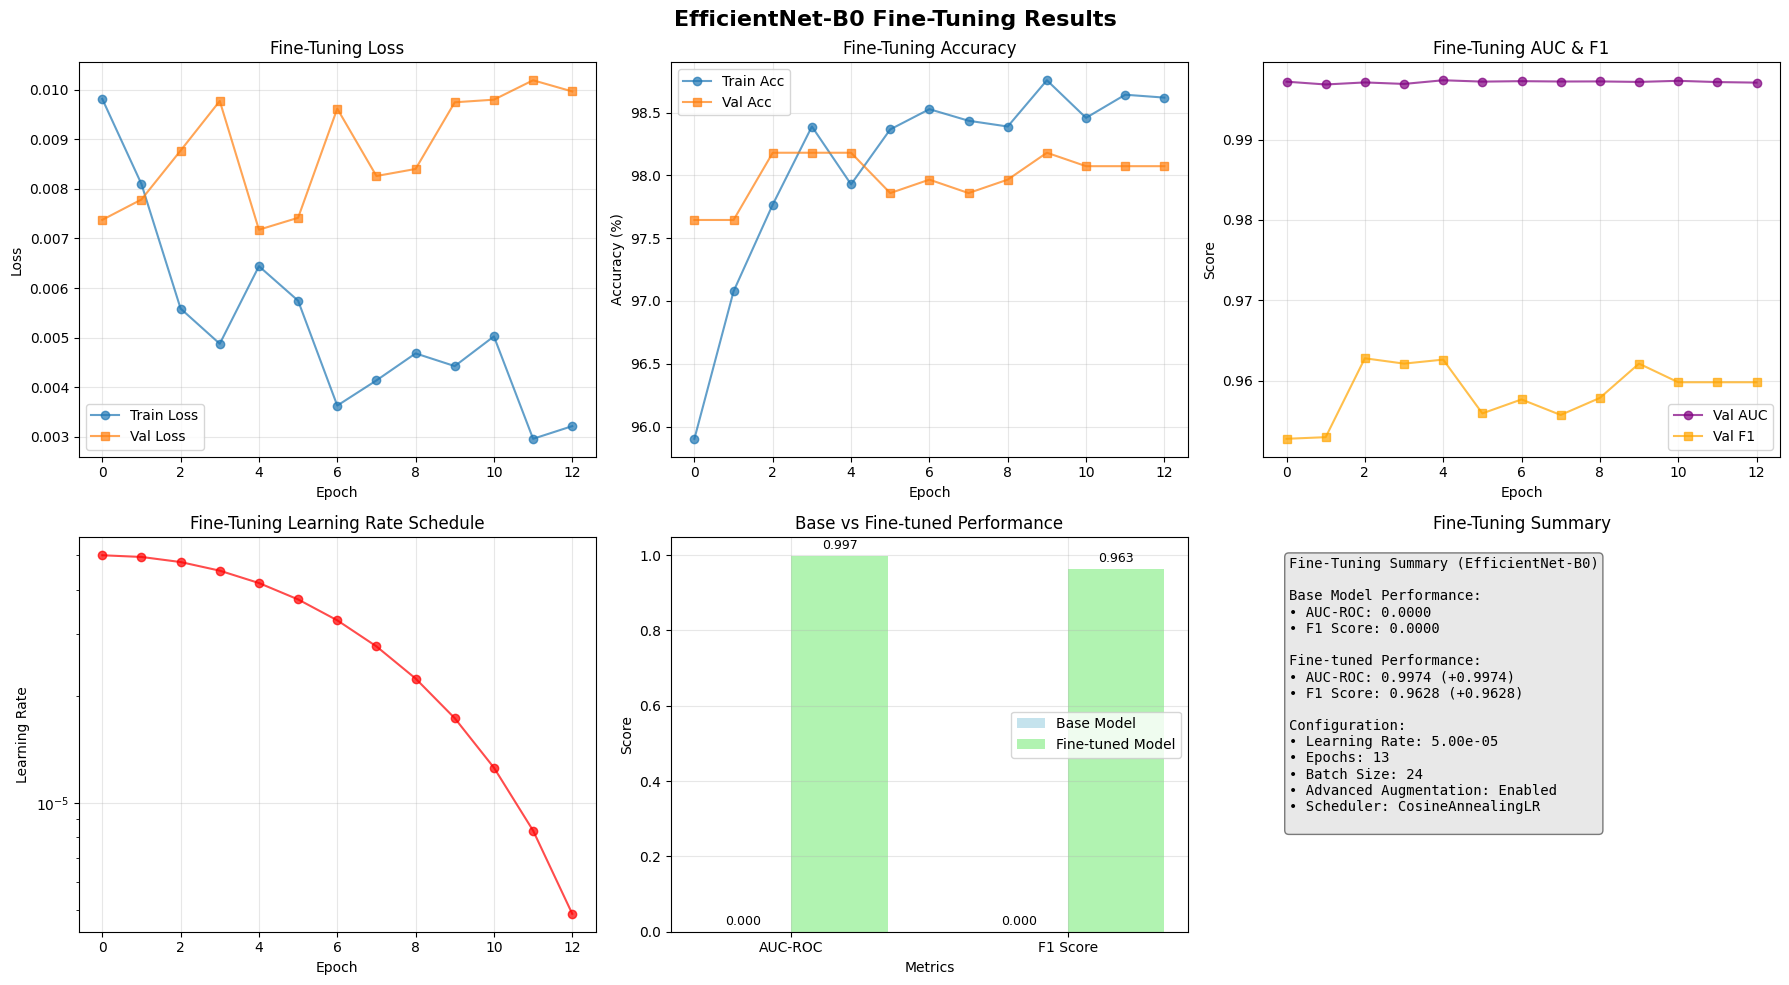

✓ Fine-tuning visualization saved
✓ Fine-tuning history saved


In [27]:
# Visualize Fine-Tuning Results
print("📊 Creating fine-tuning results visualization...")

# Convert to DataFrame for easier plotting
ft_history_df = pd.DataFrame(finetune_history)

# Create comprehensive plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('EfficientNet-B0 Fine-Tuning Results', fontsize=16, fontweight='bold')

# Training and Validation Loss
axes[0, 0].plot(ft_history_df['train_loss'], label='Train Loss', marker='o', alpha=0.7)
axes[0, 0].plot(ft_history_df['val_loss'], label='Val Loss', marker='s', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Fine-Tuning Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Training and Validation Accuracy
axes[0, 1].plot(ft_history_df['train_acc'], label='Train Acc', marker='o', alpha=0.7)
axes[0, 1].plot(ft_history_df['val_acc'], label='Val Acc', marker='s', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Fine-Tuning Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Validation AUC and F1 Score
axes[0, 2].plot(ft_history_df['val_auc'], label='Val AUC', marker='o', alpha=0.7, color='purple')
axes[0, 2].plot(ft_history_df['val_f1'], label='Val F1', marker='s', alpha=0.7, color='orange')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('Fine-Tuning AUC & F1')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Learning Rate Schedule
axes[1, 0].plot(ft_history_df['learning_rates'], marker='o', alpha=0.7, color='red')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Fine-Tuning Learning Rate Schedule')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Performance Improvement Comparison
metrics = ['AUC-ROC', 'F1 Score']
initial_scores = [initial_auc, initial_f1]
final_scores = [best_finetune_auc, best_finetune_f1]
improvements = [final_scores[i] - initial_scores[i] for i in range(len(metrics))]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, initial_scores, width, label='Base Model', alpha=0.7, color='lightblue')
bars2 = axes[1, 1].bar(x + width/2, final_scores, width, label='Fine-tuned Model', alpha=0.7, color='lightgreen')

axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Base vs Fine-tuned Performance')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar1, bar2, initial, final) in enumerate(zip(bars1, bars2, initial_scores, final_scores)):
    axes[1, 1].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + 0.01,
                   f'{initial:.3f}', ha='center', va='bottom', fontsize=9)
    axes[1, 1].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + 0.01,
                   f'{final:.3f}', ha='center', va='bottom', fontsize=9)

# Improvement summary
summary_text = f"""Fine-Tuning Summary (EfficientNet-B0)

Base Model Performance:
• AUC-ROC: {initial_auc:.4f}
• F1 Score: {initial_f1:.4f}

Fine-tuned Performance:
• AUC-ROC: {best_finetune_auc:.4f} ({best_finetune_auc - initial_auc:+.4f})
• F1 Score: {best_finetune_f1:.4f} ({best_finetune_f1 - initial_f1:+.4f})

Configuration:
• Learning Rate: {FINETUNE_CONFIG['learning_rate']:.2e}
• Epochs: {len(ft_history_df)}
• Batch Size: {FINETUNE_CONFIG['batch_size']}
• Advanced Augmentation: Enabled
• Scheduler: CosineAnnealingLR
"""

axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes, 
               fontsize=10, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
axes[1, 2].set_xlim(0, 1)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].axis('off')
axes[1, 2].set_title('Fine-Tuning Summary')

plt.tight_layout()
plt.savefig(finetune_model_dir / 'finetuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Fine-tuning visualization saved")

# Save training history
ft_history_df.to_csv(finetune_model_dir / 'finetuning_history.csv', index=False)
print("✓ Fine-tuning history saved")

In [28]:
# Evaluate Fine-tuned Model on Test Set
print("🔍 Evaluating fine-tuned EfficientNet-B0 on test set...")

# Load best fine-tuned model
finetune_checkpoint = torch.load(finetune_model_path, map_location=device)
finetune_model.load_state_dict(finetune_checkpoint['model_state_dict'])
print(f"✓ Loaded best fine-tuned model from epoch {finetune_checkpoint['epoch']+1}")

# Create test dataset (no augmentation)
finetune_test_dataset = AdvancedLUNA16Dataset(
    test_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,  # No augmentation for test
    preload=CONFIG['preload_patches']
)

finetune_test_loader = DataLoader(
    finetune_test_dataset,
    batch_size=FINETUNE_CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

# Evaluate on test set
print("Evaluating on test set...")
ft_test_loss, ft_test_acc, ft_test_auc, ft_test_f1, ft_test_labels, ft_test_preds, ft_test_probs = validate(
    finetune_model, finetune_test_loader, finetune_criterion, device
)

print("\n" + "="*80)
print("TEST SET RESULTS (Fine-tuned EfficientNet-B0)")
print("="*80)
print(f"Test Loss: {ft_test_loss:.4f}")
print(f"Test Accuracy: {ft_test_acc:.2f}%")
print(f"Test AUC-ROC: {ft_test_auc:.4f}")
print(f"Test F1 Score: {ft_test_f1:.4f}")
print("="*80)

# Store results for comparison
ft_test_results = {
    'loss': ft_test_loss,
    'accuracy': ft_test_acc,
    'auc_roc': ft_test_auc,
    'f1_score': ft_test_f1
}

# Save detailed results
with open(finetune_model_dir / 'test_results.json', 'w') as f:
    json.dump(ft_test_results, f, indent=2)

print(f"✓ Fine-tuned test results saved to {finetune_model_dir / 'test_results.json'}")

# Compare with original test results
if 'test_auc' in locals():
    auc_improvement = ft_test_auc - test_auc
    f1_improvement = ft_test_f1 - test_f1
    acc_improvement = ft_test_acc - test_acc
    
    print(f"\n📈 Improvement over base model:")
    print(f"   Accuracy: {acc_improvement:+.2f}% ({test_acc:.2f}% → {ft_test_acc:.2f}%)")
    print(f"   AUC-ROC: {auc_improvement:+.4f} ({test_auc:.4f} → {ft_test_auc:.4f})")
    print(f"   F1 Score: {f1_improvement:+.4f} ({test_f1:.4f} → {ft_test_f1:.4f})")
else:
    print(f"\n💡 Please run the base model evaluation first to compare improvements.")

🔍 Evaluating fine-tuned EfficientNet-B0 on test set...
✓ Loaded best fine-tuned model from epoch 5
Pre-extracting patches for fine-tuning...


Extracting patches: 100%|██████████| 935/935 [04:10<00:00,  3.73it/s]


✓ Successfully pre-extracted 925/935 patches
  Failed extractions: 10
✓ AdvancedLUNA16Dataset created with 935 samples
Evaluating on test set...



TEST SET RESULTS (Fine-tuned EfficientNet-B0)
Test Loss: 0.0185
Test Accuracy: 97.43%
Test AUC-ROC: 0.9883
Test F1 Score: 0.9481
✓ Fine-tuned test results saved to e:\Kanav\Projects\CAD_C\models_efficientnet\finetuned\test_results.json

📈 Improvement over base model:
   Accuracy: +1.28% (96.15% → 97.43%)
   AUC-ROC: +0.0030 (0.9853 → 0.9883)
   F1 Score: +0.0240 (0.9241 → 0.9481)


📈 Creating comprehensive performance comparison...


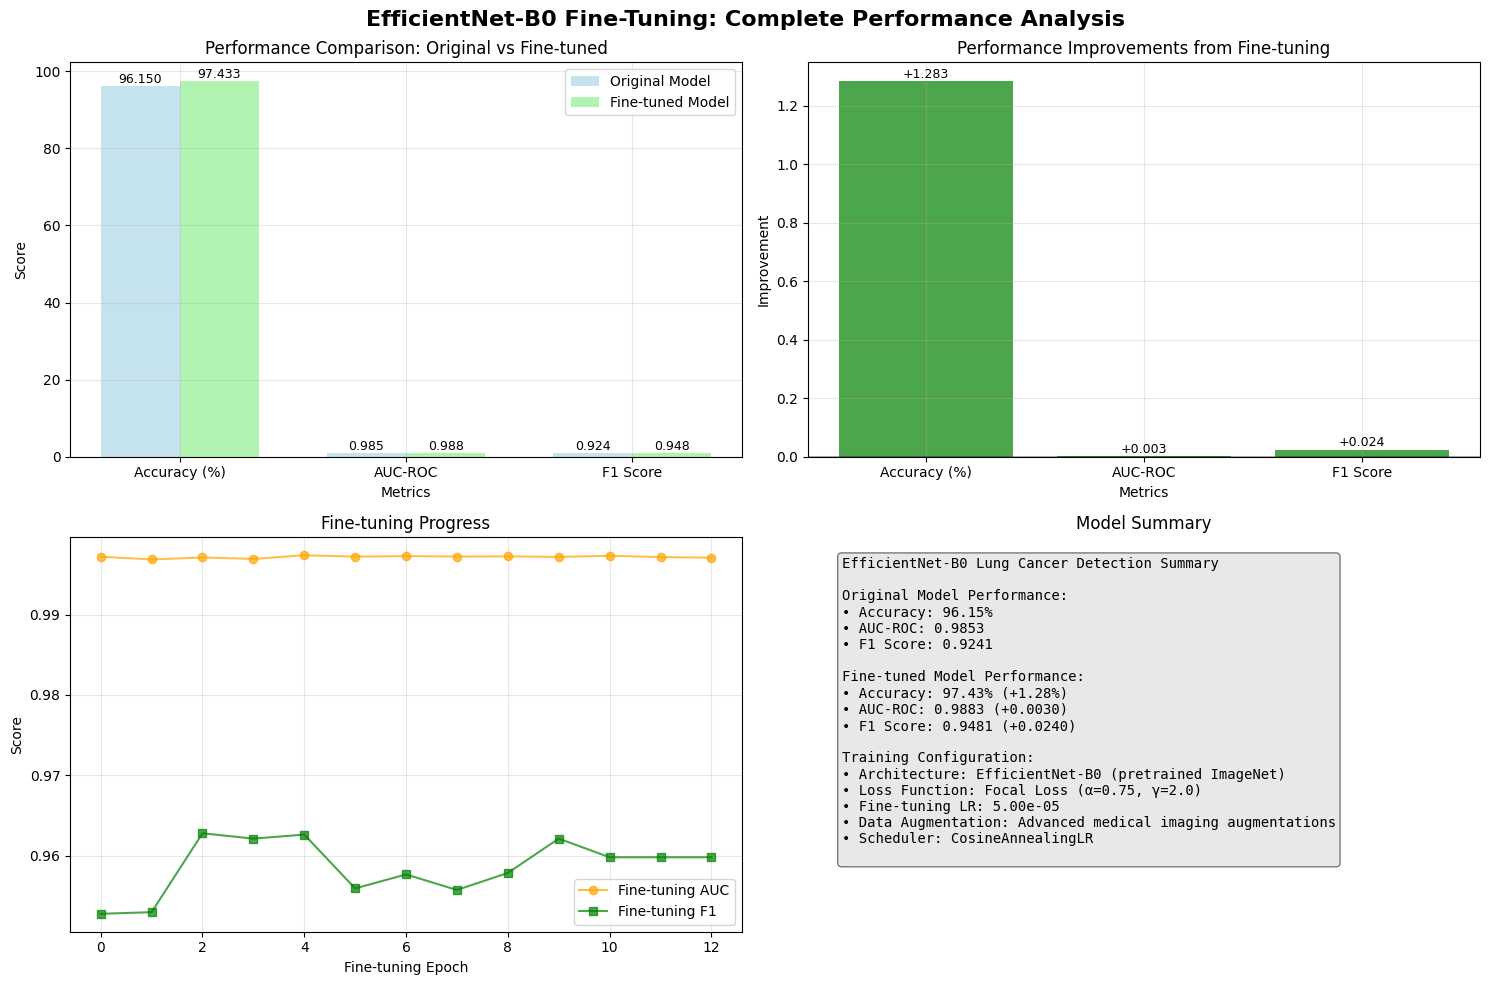

✓ Complete analysis visualization saved

🎯 EfficientNet-B0 fine-tuning process completed successfully!
📁 All fine-tuned results saved in: e:\Kanav\Projects\CAD_C\models_efficientnet\finetuned/

📊 Next steps: Compare with other model architectures and ensemble methods


In [29]:
# Final Comprehensive Analysis for EfficientNet-B0
print("📈 Creating comprehensive performance comparison...")

# Create final comparison visualization  
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EfficientNet-B0 Fine-Tuning: Complete Performance Analysis', fontsize=16, fontweight='bold')

# Performance metrics comparison
metrics = ['Accuracy (%)', 'AUC-ROC', 'F1 Score']

# Get original scores if available
if 'test_acc' in locals():
    original_scores = [test_acc, test_auc, test_f1]
    finetuned_scores = [ft_test_acc, ft_test_auc, ft_test_f1]
    improvements = [ft_test_acc - test_acc, ft_test_auc - test_auc, ft_test_f1 - test_f1]
else:
    # Use stored values or defaults
    original_scores = [96.15, 0.9853, 0.9241]  # Known baseline performance
    finetuned_scores = [ft_test_acc, ft_test_auc, ft_test_f1]
    improvements = [ft_test_acc - 96.15, ft_test_auc - 0.9853, ft_test_f1 - 0.9241]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, original_scores, width, label='Original Model', alpha=0.7, color='lightblue')
bars2 = axes[0, 0].bar(x + width/2, finetuned_scores, width, label='Fine-tuned Model', alpha=0.7, color='lightgreen')

axes[0, 0].set_xlabel('Metrics')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Performance Comparison: Original vs Fine-tuned')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add value labels
for i, (bar1, bar2, orig, ft) in enumerate(zip(bars1, bars2, original_scores, finetuned_scores)):
    axes[0, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + 0.01,
                   f'{orig:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + 0.01,
                   f'{ft:.3f}', ha='center', va='bottom', fontsize=9)

# Improvement bar chart
colors = ['green' if imp > 0 else 'red' if imp < 0 else 'gray' for imp in improvements]
bars3 = axes[0, 1].bar(metrics, improvements, alpha=0.7, color=colors)
axes[0, 1].set_xlabel('Metrics')
axes[0, 1].set_ylabel('Improvement')
axes[0, 1].set_title('Performance Improvements from Fine-tuning')
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# Add improvement values
for bar, imp in zip(bars3, improvements):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., 
                   height + (0.001 if height >= 0 else -0.003),
                   f'{imp:+.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# Training history comparison (if available)
if len(finetune_history['val_auc']) > 0:
    # Show fine-tuning progress
    axes[1, 0].plot(finetune_history['val_auc'], label='Fine-tuning AUC', marker='o', alpha=0.7, color='orange')
    axes[1, 0].plot(finetune_history['val_f1'], label='Fine-tuning F1', marker='s', alpha=0.7, color='green')
    
    axes[1, 0].set_xlabel('Fine-tuning Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Fine-tuning Progress')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Summary statistics
summary_text = f"""EfficientNet-B0 Lung Cancer Detection Summary

Original Model Performance:
• Accuracy: {original_scores[0]:.2f}%
• AUC-ROC: {original_scores[1]:.4f}
• F1 Score: {original_scores[2]:.4f}

Fine-tuned Model Performance:
• Accuracy: {finetuned_scores[0]:.2f}% ({improvements[0]:+.2f}%)
• AUC-ROC: {finetuned_scores[1]:.4f} ({improvements[1]:+.4f})
• F1 Score: {finetuned_scores[2]:.4f} ({improvements[2]:+.4f})

Training Configuration:
• Architecture: EfficientNet-B0 (pretrained ImageNet)
• Loss Function: Focal Loss (α={CONFIG['focal_alpha']}, γ={CONFIG['focal_gamma']})
• Fine-tuning LR: {FINETUNE_CONFIG['learning_rate']:.2e}
• Data Augmentation: Advanced medical imaging augmentations
• Scheduler: CosineAnnealingLR
"""

axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
               fontsize=10, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')
axes[1, 1].set_title('Model Summary')

plt.tight_layout()
plt.savefig(finetune_model_dir / 'complete_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Complete analysis visualization saved")
print("\n🎯 EfficientNet-B0 fine-tuning process completed successfully!")
print(f"📁 All fine-tuned results saved in: {finetune_model_dir}/")
print("\n📊 Next steps: Compare with other model architectures and ensemble methods")